In [2]:
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random

base_dir = 'E:/Work/Projects/ToGit/Alexa_Project3/Classification/'

dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    labeldirs = ['dogs/', 'cats/']
    for labeldir in labeldirs:
        newdir = dataset_home + subdir + labeldir
        makedirs(newdir, exist_ok = True)
        
seed(1)
val_ratio = 0.25
src_directory = base_dir + 'train/'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random() < val_ratio:
        dst_dir = 'test/'
    if file.startswith('cat'):
        dst = dataset_home + dst_dir + 'cats/' + file
        copyfile(src, dst)
    elif file.startswith('dog'):
        dst = dataset_home + dst_dir + 'dogs/' + file
        copyfile(src, dst)

In [15]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.models import Model
from keras import applications
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

pre_trained_model = keras.applications.VGG16(input_shape=(150, 150, 3), include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), metrics=['accuracy'])

model.summary()

train_datagen = ImageDataGenerator(rescale = 1. / 255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1. / 255)

train_set = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/', target_size = (150, 150), batch_size = 20, class_mode = 'binary')
test_set = train_datagen.flow_from_directory('dataset_dogs_vs_cats/test/', class_mode = 'binary', batch_size = 20, target_size = (150, 150))

history = model.fit(train_set, steps_per_epoch = len(train_set), epochs = 10, validation_data = test_set, validation_steps = len(test_set))

model.save('model.h5')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

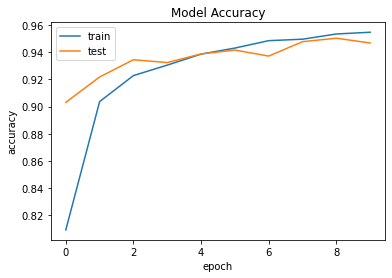

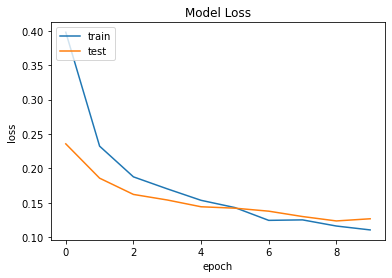

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [17]:
from keras.preprocessing import image
from os.path import isfile, join

predict_dir_path=base_dir + 'predict/'
files = [f for f in listdir(predict_dir_path) if isfile(join(predict_dir_path, f))]

for file in files:    
    predict = image.load_img(predict_dir_path + file, target_size = (150, 150))   
    predict_modified = image.img_to_array(predict)
    predict_modified = predict_modified / 255
    predict_modified = np.expand_dims(predict_modified, axis = 0)
    result = model.predict(predict_modified)
    if result[0][0] >= 0.5:
        print("Prediction = dog ")
        print ("Probability = " + str(result[0][0]))
    else:
        print("Prediction = cat")
        print ("Probability = " + str(1 - result[0][0]))

Prediction = dog 
Probability = 0.9999872
Prediction = cat
Probability = 0.9999865419076741
Prediction = cat
Probability = 0.9973436892032623
Prediction = cat
Probability = 0.9989097118377686
Prediction = dog 
Probability = 0.9999759
